In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [19]:
# Load only the required columns
cols_to_load = ['W', 'S', 'Q', 'U', 'H', 'D50', 'D84', 'R', 'qs']
df = pd.read_excel(r'D:/paper/qb/data/lab_data.xlsx', usecols=cols_to_load)
df.head()

,W,S,Q,U,H,D50,D84,R,qs
0,0.300,0.0104,0.02747,1.06,0.087,0.0068,0.00816,0.0721,24.1
1,0.300,0.0141,0.01566,0.92,0.057,0.0068,0.00816,0.0504,6.1
2,0.823,0.0143,0.02288,0.69,0.040,0.0068,0.00816,0.0389,0.2
3,0.823,0.0145,0.04978,0.82,0.074,0.0068,0.00816,0.0709,21.9
4,0.823,0.0153,0.03582,0.78,0.056,0.0068,0.00816,0.0535,1.8


In [20]:
X=df.loc[:, [ 'W','S','Q','U','H','D50','D84','R']].values
y=df.loc[:, [ 'qs']].values
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler().fit(X)
X1 = scaler1.transform(X)
scaler2 = MinMaxScaler().fit(y)
y1 = scaler2.transform(y)

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Create the sensitivity dictionary using the training set
sensitivity_dict = {
    'W': X_train[1:5, 0],
    'S': X_train[1:5, 1],
    'Q': X_train[1:5, 2],
    'U': X_train[1:5, 3],
    'H': X_train[1:5, 4],
    'D50': X_train[1:5, 5],
    'D84': X_train[1:5, 6],
    'R': X_train[1:5, 7]
}


In [22]:
svr_rbf = SVR(kernel="rbf", C=100, gamma='scale', epsilon=0.001)
md=svr_rbf.fit(X1,y1)

c:\Users\Mehdi\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
def my_model(W, S, Q, U, H, D50, D84, R):
    x_test = np.column_stack((W, S, Q, U, H, D50, D84, R))
    y_pred = svr_rbf.predict(x_test)
    return y_pred


In [24]:
from joblib import Parallel, delayed
from sensitivity import SensitivityAnalyzer

# Modify the SensitivityAnalyzer to use parallel computation
class ParallelSensitivityAnalyzer(SensitivityAnalyzer):
    def analyze(self, n_jobs=-1):
        results = Parallel(n_jobs=n_jobs)(delayed(self._analyze_param)(param) for param in self.params)
        return {param: result for param, result in zip(self.params, results)}

# Use the ParallelSensitivityAnalyzer for faster sensitivity analysis
sa = ParallelSensitivityAnalyzer(sensitivity_dict, my_model)


100%|██████████| 65536/65536 [02:15<00:00, 482.36it/s] 


,0.000050,0.001206,0.020652,0.045274
W,,,,
0.157368,0.000952,0.001022,0.002379,0.004588
0.157895,0.000946,0.001016,0.002374,0.004583
0.204211,0.000489,0.000558,0.001914,0.004133
0.378421,0.001334,0.001364,0.002078,0.003529


,0.002629,0.003796,0.006158,0.006828
W,,,,
0.157368,0.002176,0.002206,0.002270,0.002289
0.157895,0.002170,0.002200,0.002265,0.002284
0.204211,0.001722,0.001748,0.001803,0.001820
0.378421,0.002057,0.002066,0.002088,0.002095


,0.056391,0.120301,0.157895,0.233083
W,,,,
0.157368,0.001997,0.002640,0.002399,0.001905
0.157895,0.001989,0.002633,0.002394,0.001904
0.204211,0.001312,0.002039,0.001948,0.001794
0.378421,0.001521,0.001804,0.002021,0.002960


,0.023084,0.057248,0.071099,0.128347
W,,,,
0.157368,0.003240,0.001851,0.001583,0.002268
0.157895,0.003237,0.001846,0.001578,0.002258
0.204211,0.002981,0.001472,0.001142,0.001498
0.378421,0.003253,0.001821,0.001497,0.001735


,0.004545,0.025000,0.050000,0.077273
W,,,,
0.157368,0.002918,0.002193,0.001817,0.002012
0.157895,0.002913,0.002187,0.001812,0.002007
0.204211,0.002455,0.001716,0.001346,0.001576
0.378421,0.003276,0.002249,0.001494,0.001286


,0.004545,0.025000,0.050000,0.077273
W,,,,
0.157368,0.002918,0.002193,0.001817,0.002012
0.157895,0.002913,0.002187,0.001812,0.002007
0.204211,0.002455,0.001716,0.001346,0.001576
0.378421,0.003276,0.002249,0.001494,0.001286


,0.026640,0.057354,0.067812,0.111955
W,,,,
0.157368,0.001232,0.001928,0.002209,0.003571
0.157895,0.001225,0.001923,0.002204,0.003568
0.204211,0.000654,0.001451,0.001762,0.003226
0.378421,0.001161,0.001774,0.002032,0.003339


,0.002629,0.003796,0.006158,0.006828
S,,,,
0.000050,0.000883,0.000906,0.000958,0.000974
0.001206,0.000943,0.000966,0.001018,0.001034
0.020652,0.002139,0.002162,0.002214,0.002230
0.045274,0.004161,0.004184,0.004236,0.004252


,0.056391,0.120301,0.157895,0.233083
S,,,,
0.000050,0.000341,0.001153,0.001159,0.001068
0.001206,0.000410,0.001211,0.001213,0.001127
0.020652,0.001813,0.002378,0.002289,0.002264
0.045274,0.004254,0.004373,0.004101,0.004104


,0.023084,0.057248,0.071099,0.128347
S,,,,
0.000050,0.002435,0.000699,0.000280,0.000307
0.001206,0.002471,0.000753,0.000341,0.000396
0.020652,0.003223,0.001840,0.001560,0.002122
0.045274,0.004581,0.003700,0.003618,0.004934


,0.004545,0.025000,0.050000,0.077273
S,,,,
0.000050,0.001763,0.000941,0.000459,0.000558
0.001206,0.001821,0.001001,0.000520,0.000620
0.020652,0.002984,0.002189,0.001730,0.001841
0.045274,0.004996,0.004214,0.003760,0.003863


,0.004545,0.025000,0.050000,0.077273
S,,,,
0.000050,0.001763,0.000941,0.000459,0.000558
0.001206,0.001821,0.001001,0.000520,0.000620
0.020652,0.002984,0.002189,0.001730,0.001841
0.045274,0.004996,0.004214,0.003760,0.003863


,0.026640,0.057354,0.067812,0.111955
S,,,,
0.000050,0.000316,0.000695,0.000872,0.001838
0.001206,0.000353,0.000750,0.000934,0.001923
0.020652,0.001117,0.001866,0.002164,0.003598
0.045274,0.002487,0.003765,0.004236,0.006345


,0.056391,0.120301,0.157895,0.233083
Q,,,,
0.002629,0.001640,0.002224,0.002144,0.002118
0.003796,0.001672,0.002251,0.002167,0.002129
0.006158,0.001743,0.002311,0.002218,0.002154
0.006828,0.001764,0.002329,0.002234,0.002162


,0.023084,0.057248,0.071099,0.128347
Q,,,,
0.002629,0.003129,0.001700,0.001402,0.001895
0.003796,0.003153,0.001723,0.001426,0.001917
0.006158,0.003206,0.001776,0.001478,0.001966
0.006828,0.003222,0.001792,0.001494,0.001981


,0.004545,0.025000,0.050000,0.077273
Q,,,,
0.002629,0.002850,0.002042,0.001568,0.001666
0.003796,0.002870,0.002064,0.001592,0.001693
0.006158,0.002914,0.002113,0.001646,0.001752
0.006828,0.002928,0.002127,0.001663,0.001770


,0.004545,0.025000,0.050000,0.077273
Q,,,,
0.002629,0.002850,0.002042,0.001568,0.001666
0.003796,0.002870,0.002064,0.001592,0.001693
0.006158,0.002914,0.002113,0.001646,0.001752
0.006828,0.002928,0.002127,0.001663,0.001770


,0.026640,0.057354,0.067812,0.111955
Q,,,,
0.002629,0.001020,0.001721,0.002004,0.003380
0.003796,0.001044,0.001745,0.002028,0.003403
0.006158,0.001096,0.001797,0.002080,0.003453
0.006828,0.001112,0.001813,0.002095,0.003468


,0.023084,0.057248,0.071099,0.128347
U,,,,
0.056391,0.003101,0.001505,0.001114,0.001098
0.120301,0.003062,0.001885,0.001680,0.002488
0.157895,0.002935,0.001759,0.001568,0.002501
0.233083,0.003613,0.001841,0.001438,0.001671


,0.004545,0.025000,0.050000,0.077273
U,,,,
0.056391,0.002710,0.001747,0.001150,0.001212
0.120301,0.003119,0.002296,0.001806,0.001894
0.157895,0.002968,0.002202,0.001752,0.001841
0.233083,0.002766,0.002101,0.001761,0.001935


,0.004545,0.025000,0.050000,0.077273
U,,,,
0.056391,0.002710,0.001747,0.001150,0.001212
0.120301,0.003119,0.002296,0.001806,0.001894
0.157895,0.002968,0.002202,0.001752,0.001841
0.233083,0.002766,0.002101,0.001761,0.001935


,0.026640,0.057354,0.067812,0.111955
U,,,,
0.056391,0.000663,0.001431,0.001717,0.003008
0.120301,0.001376,0.002019,0.002270,0.003449
0.157895,0.001315,0.001913,0.002159,0.003376
0.233083,0.000919,0.001713,0.002060,0.003871


,0.004545,0.025000,0.050000,0.077273
H,,,,
0.023084,0.004329,0.003313,0.002602,0.002465
0.057248,0.002654,0.001789,0.001253,0.001295
0.071099,0.002254,0.001453,0.000990,0.001103
0.128347,0.002325,0.001791,0.001624,0.002019


,0.004545,0.025000,0.050000,0.077273
H,,,,
0.023084,0.004329,0.003313,0.002602,0.002465
0.057248,0.002654,0.001789,0.001253,0.001295
0.071099,0.002254,0.001453,0.000990,0.001103
0.128347,0.002325,0.001791,0.001624,0.002019


,0.026640,0.057354,0.067812,0.111955
H,,,,
0.023084,0.001173,0.002627,0.003178,0.005732
0.057248,0.000436,0.001365,0.001729,0.003462
0.071099,0.000435,0.001139,0.001423,0.002803
0.128347,0.002229,0.001945,0.001877,0.001708


,0.004545,0.025000,0.050000,0.077273
D50,,,,
0.004545,0.003620,0.002839,0.002439,0.002665
0.025000,0.002839,0.002059,0.001637,0.001811
0.050000,0.002439,0.001637,0.001158,0.001235
0.077273,0.002665,0.001811,0.001235,0.001171


,0.026640,0.057354,0.067812,0.111955
D50,,,,
0.004545,0.001408,0.002482,0.002891,0.004782
0.025000,0.000912,0.001743,0.002069,0.003622
0.050000,0.000776,0.001343,0.001581,0.002769
0.077273,0.001177,0.001508,0.001666,0.002531


,0.026640,0.057354,0.067812,0.111955
D84,,,,
0.004545,0.001408,0.002482,0.002891,0.004782
0.025000,0.000912,0.001743,0.002069,0.003622
0.050000,0.000776,0.001343,0.001581,0.002769
0.077273,0.001177,0.001508,0.001666,0.002531


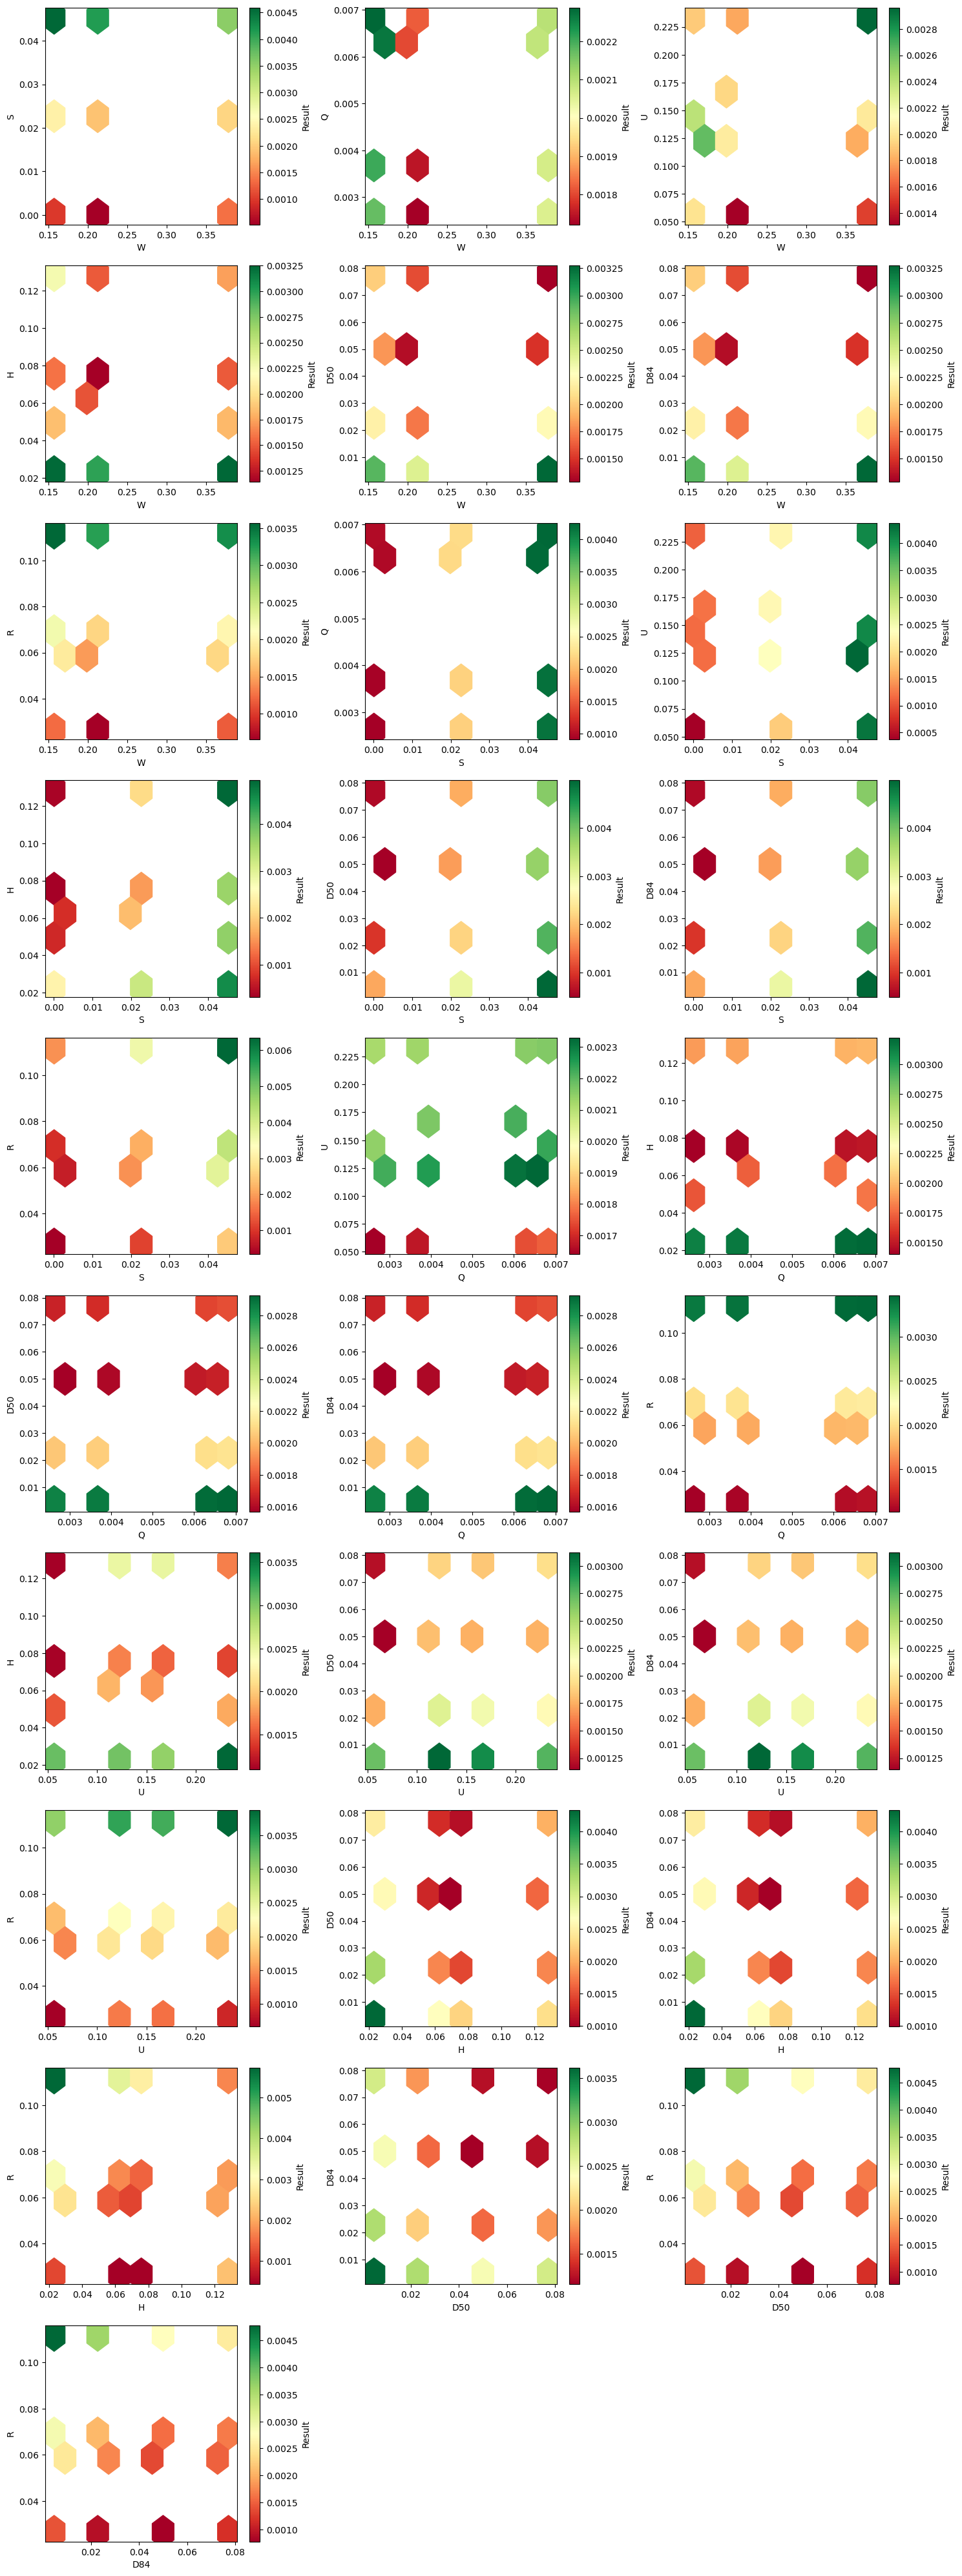

In [25]:
plot = sa.plot()
styled_df = sa.styled_dfs()